In [1]:
!pip freeze

accelerate==0.31.0
aiohttp==3.9.5
aiosignal==1.3.1
altair==5.3.0
annotated-types==0.7.0
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
Babel==2.15.0
beautifulsoup4==4.12.3
bitsandbytes==0.43.1
bleach==6.1.0
blinker==1.8.2
cachetools==5.3.3
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpickle==3.0.0
cmake==3.29.6
comm==0.2.2
contourpy==1.2.1
cycler==0.12.1
datasets==2.20.0
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
diskcache==5.6.3
distro==1.9.0
dnspython==2.6.1
email_validator==2.2.0
et-xmlfile==1.1.0
exceptiongroup==1.2.1
executing==2.0.1
fastapi==0.111.0
fastapi-cli==0.0.4
fastjsonschema==2.20.0
filelock==3.15.4
fonttools==4.53.0
fqdn==1.5.1
frozenlist==1.4.1
fsspec==2023.9.2
gitdb==4.0.11
GitPython==3.1.43
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httptools==0.6.1
httpx==0.27.0
huggingface-hub==0.23.4
ibm-cos-sdk==2.13.5
ibm-cos-sdk-core=

In [2]:
import pandas as pd
import re
import warnings
from sql_metadata import Parser
from matplotlib import pyplot as plt
import json
import logging
import ibm_db

import sqlite3
from tqdm import tqdm
from itertools import product
from collections import defaultdict
import random
from datetime import datetime
import os
from math import ceil
import random
import sys
from datasets import load_dataset



warnings.filterwarnings('ignore')

In [3]:
ls ../input/sirion_dataset_v3

codellama_codellama-34b-instruct_data.csv
deepseek-ai_deepseek-coder-33b-instruct_data.csv
ibm_granite-13b-instruct-v2_data.csv
ibm_granite-20b-code-instruct_data.csv
ibm_granite-34b-code-instruct_data.csv
ibm_granite-8b-code-instruct_data.csv
kaist-ai_prometheus-8x7b-v2_data.csv
meta-llama_llama-3-70b-instruct_data.csv
mistralai_mixtral-8x7b-instruct-v01_data.csv


### Helper variables Functions

In [4]:
query_keywords_list = [
    "TOP","EXISTS","INTERSECT","SELECT","DISTINCT","RANK","AS",
    "WHERE","AND","OR","BETWEEN","LIKE","COUNT","SUM","AVG",
    "MIN","MAX","GROUP BY","ORDER BY","DESC","OFFSET","FETCH",
    "INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION",
    "HAVING","JOIN"
]
aggregate_keywords = ["COUNT","SUM","AVG","MIN","MAX","TOP"]
rank_keywords = ["RANK"]
fillter_keywords = ["GROUP BY","ORDER BY","FILTER","HAVING","EXISTS"]
join_keywords = [
    "JOIN","INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION","INTERSECT"
]
orderby_keywords = ["ORDER BY"]
groupby_keywords = ["GROUP BY"]
where_keywords =["WHERE"]
date_keywords =[
    "NOW","GETDATE","CURRENT_TIMESTAMP","DATEDIFF","DATEADD","YEAR","DAY","MONTH"
]
keyword_pattern = re.compile(r'\b(?:' + '|'.join(query_keywords_list) + r')\b', re.IGNORECASE)

def calculate_classification_new(df):
    ## Create new 3 columns 
    df["Expected count"] = df.index
    df["Expected difficulty"] = df.index
    df["Expected classification_new"] = df.index
    for index, row in df.iterrows():
        sql = row["expected query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in orderby_keywords:
                    classification = "ORDER BY"
                elif keyword in groupby_keywords:
                    classification = "GROUP BY"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE/RATIO"
                elif keyword in join_keywords:
                    classification = "JOIN"
                elif keyword in where_keywords:
                    classification = "WHERE"
                elif keyword in date_keywords:
                    classification = "DATE"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Expected difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Expected difficulty'] ="moderate"
        else:
            df.at[index,'Expected difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Expected classification_new'] = classification
        df.at[index,'Expected count'] =count


    ## Create new 3 columns 
    df["Predicted count"] = df.index
    df["Predicted difficulty"] = df.index
    df["Predicted classification_new"] = df.index
    for index, row in df.iterrows():
        sql = row["generated query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in orderby_keywords:
                    classification = "ORDER BY"
                elif keyword in groupby_keywords:
                    classification = "GROUP BY"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE/RATIO"
                elif keyword in join_keywords:
                    classification = "JOIN"
                elif keyword in where_keywords:
                    classification = "WHERE"
                elif keyword in date_keywords:
                    classification = "DATE"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Predicted difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Predicted difficulty'] ="moderate"
        else:
            df.at[index,'Predicted difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Predicted classification_new'] = classification
        df.at[index,'Predicted count'] =count
    return df

def calculate_classification(df):
    ## Create new 3 columns 
    df["Expected count"] = df.index
    df["Expected difficulty"] = df.index
    df["Expected classification"] = df.index
    for index, row in df.iterrows():
        sql = row["expected query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in rank_keywords:
                    classification = "RANK"
                elif keyword in fillter_keywords:
                    classification = "FILTER"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE"
                elif keyword in join_keywords:
                    classification = "JOIN"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Expected difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Expected difficulty'] ="moderate"
        else:
            df.at[index,'Expected difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Expected classification'] = classification
        df.at[index,'Expected count'] =count

        ## Create new 3 columns 
    df["Predicted count"] = df.index
    df["Predicted difficulty"] = df.index
    df["Predicted classification"] = df.index
    for index, row in df.iterrows():
        sql = row["generated query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in rank_keywords:
                    classification = "RANK"
                elif keyword in fillter_keywords:
                    classification = "FILTER"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE"
                elif keyword in join_keywords:
                    classification = "JOIN"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Predicted difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Predicted difficulty'] ="moderate"
        else:
            df.at[index,'Predicted difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Predicted classification'] = classification
        df.at[index,'Predicted count'] =count
    return df






# def create_db_and_table(db_name):
#     # Connect to SQLite database (or create it if it doesn't exist)
#     conn = sqlite3.connect(f"{db_name}.db")
#     cursor = conn.cursor()
    
#     # Create table
#     cursor.execute('''
#         CREATE TABLE IF NOT EXISTS contract (
#             id TEXT ,
#             supplier TEXT,
#             services TEXT,
#             effective_date TEXT,
#             keywords TEXT,
#             document_type TEXT,
#             expiration_date TEXT,
#             created_by TEXT,
#             region TEXT,
#             tcv REAL,
#             term_type TEXT,
#             title TEXT,
#             keyword TEXT,
#             status TEXT,
#             functions TEXT,
#             countries TEXT,
#             regions TEXT
#         )
#     ''')
    
#     # Commit changes and close connection
#     conn.commit()
#     conn.close()



# def check_database_schema(db_path):
#     # Connect to the SQLite database
#     conn = sqlite3.connect(db_path)
#     cursor = conn.cursor()
    
#     # Fetch and print all table names in the database
#     cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#     tables = cursor.fetchall()
#     print("Tables in the database:", tables)
    
#     # Check for 'contract' table and print its schema
#     cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='contract';")
#     if cursor.fetchone():
#         print("Table 'contract' exists. Schema:")
#         cursor.execute("PRAGMA table_info('contract');")
#         columns = cursor.fetchall()
#         for column in columns:
#             print(column)
#     else:
#         print("Table 'contract' does not exist in the database.")

#     # Close the connection
#     conn.close()


def isValidSQL(sql, db):
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    try:
        cursor.execute(sql)
    except:
        return False
    return True


def query_processing(row,expected_query_column,generated_query_column):
    g_str =''
    p_str=''
    
    if ';' not in row[expected_query_column]:
        g_str = row[expected_query_column]+" ;"
    else:
        g_str = row[expected_query_column]
    
    if ';' not in str(row[generated_query_column]):
        p_str = str(row[generated_query_column])+" ;"
    else:
        p_str = str(row[generated_query_column]).split(";")[0]
        
    p_str = p_str.replace("> =", ">=").replace("< =", "<=").replace("! =", "!=")
    
    g_str = g_str.replace('``` ',"").replace('`',"")
    p_str = p_str.replace('``` ',"").replace('`',"")
    g_str = g_str.replace('" ',"")
    p_str = p_str.replace('" ',"")
    p_str = p_str.replace('### Expected Output:   ',"").replace('`',"")
    p_str = p_str.replace('Note:',"")
    p_str = p_str.replace(' Ex',"")
    p_str = p_str.replace('Here is the',"")
    p_str = p_str.split("### Explanation:")[0]
    p_str = p_str.split("Explanation: ")[0]
    p_str = p_str.split(": Explanation:")[0]
    p_str = p_str.split("Explanation:")[0]
    
    p_str = p_str.replace('ILIKE',"LIKE")
    p_str = p_str.replace('ilike',"LIKE")
    
    if "### Response:" in p_str:
        p_str = p_str.split("### Response:")[1]
    p_str = p_str.replace("###","")
    
    
   
    p_str_val = p_str.split(": Answer:")
    if len(p_str_val) ==2:
        p_str = p_str_val[1]
    p_str_val = p_str.split(": Query:")
    if len(p_str_val) ==2:
        p_str = p_str_val[1]
    
    if "This query" in p_str:
         p_str = p_str.split("This query")[0]
    if "The query" in p_str:
         p_str = p_str.split("The query")[0]     
    if "The above query" in p_str:
         p_str = p_str.split("The above query")[0]
    if "planation:" in p_str:
         p_str = p_str.split("planation:")[0]
    if "This queries" in p_str:
         p_str = p_str.split("This queries")[0]
    if "noqa: E501" in p_str:
         p_str = p_str.split("noqa: E501")[0]

    p_str = p_str.split(": Result:")[0]
    p_str = p_str.split("INST ")[0]
    p_str = p_str.split(" INST")[0]
    p_str = p_str.split(" find ")[0]
    p_str = p_str.split(" INST)")[0]
    
    p_str = p_str.strip()
    g_str = g_str.strip()
    p_str = p_str.replace("#","")
    p_str = reformat_query(p_str)
    p_str = replace_cur_year(p_str)
    
    if "select" in p_str.lower():
        if ':' in p_str:
            p_str=p_str.replace(":","")
        if ';' not in p_str:
            p_str=p_str+' ;'
    return g_str, p_str


def get_category(query):
    query_keywords_list = ["TOP","EXISTS","INTERSECT","SELECT","DISTINCT","TOP","RANK","AS","WHERE","AND","OR","BETWEEN","LIKE","COUNT","SUM","AVG","MIN","MAX","GROUP BY","ORDER BY","DESC","OFFSET","FETCH","INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION","HAVING","JOIN"]
    aggregate_keywords = ["COUNT","SUM","AVG","MIN","MAX","TOP"]
    rank_keywords = ["RANK"]
    fillter_keywords = ["GROUP BY","ORDER BY","FILTER","HAVING","EXISTS"]
    join_keywords = ["JOIN","INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION","INTERSECT"]

    count =0
    orderby_keywords = ["ORDER BY"]
    groupby_keywords = ["GROUP BY"]
    where_keywords =["WHERE"]
    date_keywords =["NOW","GETDATE","CURRENT_TIMESTAMP","DATEDIFF","DATEADD","YEAR","DAY","MONTH"]
    for keyword in query_keywords_list:
        if isinstance(query,str) and keyword in query:
            count=count+1
            if keyword in orderby_keywords:
                classification = "ORDER BY"
            elif keyword in groupby_keywords:
                classification = "GROUP BY"
            elif keyword in aggregate_keywords:
                classification = "AGGREGATE/RATIO"
            elif keyword in join_keywords:
                classification = "JOIN"
            elif keyword in where_keywords:
                classification = "WHERE"
            elif keyword in date_keywords:
                classification = "DATE"
    if count < 6:
        classification="simple"
    elif count > 5 and count < 9:
        classification="moderate"
    else:
        classification ="challenging"
    if classification == '':
        classification = 'SELECT'
    return classification


def replace_cur_year(query: str) -> str:
    return re.sub(
        "YEAR\s*\(\s*CURDATE\s*\(\s*\)\s*\)\s*", "2020", query, flags=re.IGNORECASE
    )

def formaterAndCaller_db2(row,schema_name,expected_query_column,generated_query_column):
    conn = db2_connector.db2_connectorWithSchema(schema_name)

    g_str = row[expected_query_column]
    p_str =row[generated_query_column]

    eval_score1 =0
    eval_score,error,result = eval_exec_match_db2(conn,conn,p_str, g_str)
    ## For query correction:
    g_str_p1,p_str_p1 = query_processing(row,expected_query_column,generated_query_column)
    eval_score1 ,error,result = eval_exec_match_db2(conn,conn,p_str_p1, g_str_p1)

    return eval_score,eval_score1,error,result

def reformat_query(query: str) -> str:
    t_stars = ["t1.*", "t2.*", "t3.*", "T1.*", "T2.*", "T3.*"]
    for ts in t_stars:
        query = query.replace(ts, "*")
    return query


def error_handling(e):
    error ="None"
    if 'no such column' in e:
            error ="No such column"
    elif 'syntax error' in e:
            error = "Syntax error"
    elif 'no such table' in e:
            error = "No such table"
    elif 'ambiguous column name' in e:
            error = "Ambiguous column name"
    else:
        error = e
    return error


def formaterAndCaller_db2(df,row):
    conn = db2_connector.db2_connectorWithSchema(row["db_id"])

    g_str = row["query"]+";"
    p_str =row["model_op"]

    eval_score1 =0
    eval_score,error,result = eval_exec_match_db2(conn,conn,p_str, g_str)
    ## For query correction:
    if "model_op1" in df.columns:
        p_str_p =row["model_op1"]
        eval_score1 ,error,result = eval_exec_match_db2(conn,conn,p_str_p, g_str)

    return eval_score,eval_score1,error,result
    

def eval_exec_match_db2(db2_conn, db2_conn1, p_str, g_str):
    """
    Return 1 if the values between prediction and gold are matching
    in the corresponding index. Currently not support multiple col_unit(pairs).
    """
    error = 'None'
    result = "error"
    value = False

    try:
        stmt = ibm_db.exec_immediate(db2_conn, p_str)
        p_res = ibm_db.fetch_assoc(stmt)
    except Exception as e:
        error = error_handling(str(e))
        return value, error, result

    try:
        stmt = ibm_db.exec_immediate(db2_conn1, g_str)
        q_res = ibm_db.fetch_assoc(stmt)
    except Exception as e:
        error = error_handling(str(e))
        return value, error, result

    orders_matter = False
    if q_res is not None and not isinstance(p_res,bool) and not isinstance(q_res,bool) :
        value, result = result_eq_db2(p_res, q_res, order_matters=orders_matter)

    return value, error, result


def result_eq(result1, result2, order_matters):
    result ="None"
    if len(result1) == 0 and len(result2) == 0:
        result = "same"
        return True,result

    # if length is not the same, then they are definitely different bag of rows
    status =0
    if len(result1) != len(result2):
        if len(result1)==0:
            result = "P result zero"
        elif len(result2)==0:
            result = "Q result zero"
        elif len(result1) > len(result2):
            for res in result2:
                if res in result1:
                    status =1
            if status ==1:
                result = "Partial Match"
            else:
                result = "P result greater"
                
        elif len(result1) < len(result2):
            for res in result1:
                if res in result2:
                    status =1
            if status ==1:
                result = "Partial Match"
            else:   
                result = "Q result greater"    
        return False,result
        

    num_cols = len(result1[0])

    # if the results do not have the same number of columns, they are different
    if len(result2[0]) != num_cols:
        result = "column length different"
        return False,result

    # unorder each row and compare whether the denotation is the same
    # this can already find most pair of denotations that are different
    if not quick_rej(result1, result2, order_matters):
        count =0
        for res in result2:
                if res in result1:
                    count =1
        if count ==1:
            result = "Partial Match"
        else:
            result = "order or result different"
        return False,result

    # the rest of the problem is in fact more complicated than one might think
    # we want to find a permutation of column order and a permutation of row order,
    # s.t. result_1 is the same as result_2
    # we return true if we can find such column & row permutations
    # and false if we cannot
    tab1_sets_by_columns = [{row[i] for row in result1} for i in range(num_cols)]

    # on a high level, we enumerate all possible column permutations that might make result_1 == result_2
    # we decrease the size of the column permutation space by the function get_constraint_permutation
    # if one of the permutation make result_1, result_2 equivalent, then they are equivalent
    for perm in get_constraint_permutation(tab1_sets_by_columns, result2):
        if len(perm) != len(set(perm)):
            continue
        if num_cols == 1:
            result2_perm = result2
        else:
            result2_perm = [permute_tuple(element, perm) for element in result2]
        if order_matters:
            if result1 == result2_perm:
                result ="same"
                return True,result
        else:
            # in fact the first condition must hold if the second condition holds
            # but the first is way more efficient implementation-wise
            # and we use it to quickly reject impossible candidates
            if set(result1) == set(result2_perm) and multiset_eq(result1, result2_perm):
                result ="same"
                return True,result
    return False,result


# def insert_data(db_name, data):
#     # Connect to SQLite database
#     conn = sqlite3.connect(f"{db_name}.db")
#     cursor = conn.cursor()

def quick_rej(result1, result2, order_matters):
    s1 = [unorder_row(row) for row in result1]
    s2 = [unorder_row(row) for row in result2]
    if order_matters:
        return s1 == s2
    else:
        return set(s1) == set(s2)

def unorder_row(row):
    return tuple(sorted(row, key=lambda x: str(x) + str(type(x))))

def get_constraint_permutation(tab1_sets_by_columns, result2):
    num_cols = len(result2[0])
    perm_constraints = [{i for i in range(num_cols)} for _ in range(num_cols)]
    if num_cols <= 3:
        return product(*perm_constraints)

    # we sample 20 rows and constrain the space of permutations
    for _ in range(20):
        random_tab2_row = random.choice(result2)

        for tab1_col in range(num_cols):
            for tab2_col in set(perm_constraints[tab1_col]):
                if random_tab2_row[tab2_col] not in tab1_sets_by_columns[tab1_col]:
                    perm_constraints[tab1_col].remove(tab2_col)
    return product(*perm_constraints)

def permute_tuple(element, perm):
    assert len(element) == len(perm)
    return tuple([element[i] for i in perm])

def multiset_eq(l1, l2):
    if len(l1) != len(l2):
        return False
    d = defaultdict(int)
    for e in l1:
        d[e] = d[e] + 1
    for e in l2:
        d[e] = d[e] - 1
        if d[e] < 0:
            return False
    return True


# db_name = 'contracts_database'
# create_db_and_table(db_name)





# with open("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/datasets/synthetic_data.json","r") as file:
#     data = json.load(file)
#     for obj in data:
#         insert_data(db_name, obj)
# import csv
# with open("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/synthetic_data.csv", mode='w', newline='') as file:
#     # Create a writer object from csv module
#     csv_writer = csv.writer(file)
    
#     # Add column headers
#     csv_writer.writerow(data[0].keys())
    
#     # Add rows
#     for row in data:
#         csv_writer.writerow(row.values())


def tokenize_sql_query(sql_query):
    token_list = []
    try:
        for token in Parser(sql_query).tokens:
            token_list.append(str(token.value))
    except:
        pass
    return token_list


dict_accuracy_overall = {}

In [5]:
# codellama_codellama-34b-instruct_data.csv
# deepseek-ai_deepseek-coder-33b-instruct_data.csv
# ibm_granite-13b-instruct-v2_data.csv
# ibm_granite-20b-code-instruct_data.csv
# ibm_granite-34b-code-instruct_data.csv
# ibm_granite-8b-code-instruct_data.csv
# kaist-ai_prometheus-8x7b-v2_data.csv
# meta-llama_llama-3-70b-instruct_data.csv
# mistralai_mixtral-8x7b-instruct-v01_data.csv

In [6]:
import pandas as pd

pd.read_csv("../input/sirion_dataset_v3/codellama_codellama-34b-instruct_data.csv")

,question,db_id,expected query,generated query,latency
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,SELECT DISTINCT DOCUMENT_TYPE\n FROM C...,3.502429
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...",SELECT COUNT(DISTINCT SUPPLIER)\n FROM...,9.492385
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...",SELECT \n EXTRACT(YEAR FROM EFFECTI...,7.393219
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,SELECT TERM_TYPE\n FROM CONTRACT_DATA\...,3.469628
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,SELECT OBLIGATIONS\n FROM CONTRACT_DAT...,3.468878
...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","SELECT DOCUMENT_TYPE, COUNT(*) AS COUNT\n ...",8.152799
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,SELECT * FROM CONTRACT_DATA WHERE FUNCTIONS = ...,6.231640
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,SELECT * FROM CONTRACT_DATA WHERE FUNCTIONS LI...,6.645068
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,SELECT * FROM CONTRACT_DATA WHERE STATUS = 'No...,6.283967


# 1. codellama_34b_instruct

In [7]:
df = pd.read_csv("../input/sirion_dataset_v3/codellama_codellama-34b-instruct_data.csv")
df["predicted_query_toks"] = df["generated query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["expected query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df['expected_sql_classification'] = df['expected query'].apply(lambda sql: get_category(sql))
df['generated_sql_classification'] = df['generated query'].apply(lambda sql: get_category(sql))
df = calculate_classification(df,)
df = calculate_classification_new(df)

df.to_csv("../output/inference_sirion_v3/codellama_codellama-34b-instruct_data.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,question,db_id,expected query,generated query,latency,predicted_query_toks,expected_query_toks,expected_sql_classification,generated_sql_classification,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,SELECT DISTINCT DOCUMENT_TYPE\n FROM C...,3.502429,"['SELECT', 'DISTINCT', 'DOCUMENT_TYPE', 'FROM'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",simple,simple,4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...",SELECT COUNT(DISTINCT SUPPLIER)\n FROM...,9.492385,"['SELECT', 'COUNT', '(', 'DISTINCT', 'SUPPLIER...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",simple,simple,3,simple,AGGREGATE,3,simple,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...",SELECT \n EXTRACT(YEAR FROM EFFECTI...,7.393219,"['SELECT', 'EXTRACT', '(', 'YEAR', 'FROM', 'EF...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",simple,moderate,5,simple,AGGREGATE,7,moderate,FILTER,AGGREGATE/RATIO,ORDER BY
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,SELECT TERM_TYPE\n FROM CONTRACT_DATA\...,3.469628,"['SELECT', 'TERM_TYPE', 'FROM', 'CONTRACT_DATA...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",simple,simple,2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,SELECT OBLIGATIONS\n FROM CONTRACT_DAT...,3.468878,"['SELECT', 'OBLIGATIONS', 'FROM', 'CONTRACT_DA...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",simple,simple,4,simple,SELECT,2,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","SELECT DOCUMENT_TYPE, COUNT(*) AS COUNT\n ...",8.152799,"['SELECT', 'DOCUMENT_TYPE', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",moderate,moderate,8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,SELECT * FROM CONTRACT_DATA WHERE FUNCTIONS = ...,6.231640,"['SELECT', '*', 'FROM', 'CONTRACT_DATA', 'WHER...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",simple,simple,2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,SELECT * FROM CONTRACT_DATA WHERE FUNCTIONS LI...,6.645068,"['SELECT', '*', 'FROM', 'CONTRACT_DATA', 'WHER...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",simple,simple,3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,SELECT * FROM CONTRACT_DATA WHERE STATUS = 'No...,6.283967,"['SELECT', '*', 'FROM', 'CONTRACT_DATA', 'WHER...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",simple,simple,2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [8]:
conn_str = (
    "DRIVER={IBM DB2 ODBC DRIVER};"
    "DATABASE=bludb;"
    "HOSTNAME=ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud;"
    "PORT=31321;"
    "PROTOCOL=TCPIP;"
    "UID=csr11117;"
    "PWD=609Np3exGwBzg1QI;"
    "SECURITY=SSL;"
)


conn = ibm_db.connect(conn_str, "", "")
if conn:
    print("Connected to the database.")
else:
    print("Connection failed.")

    
def isValidSQLdb2(sql, conn=conn):
    try:
        stmt = ibm_db.exec_immediate(conn, sql.replace("contracts","contract.contract").replace("function","functions").replace("created_on","effective_date",).upper())#.replace("contracts","test"))
        result = []
        row = ibm_db.fetch_assoc(stmt)
        while row:
            result.append(row)
            row = ibm_db.fetch_assoc(stmt)
        
        for row in result:
            print(row)
    except:
        return False
    return True

Connected to the database.


In [9]:
ibm_db.fetch_assoc(ibm_db.exec_immediate(conn,"SELECT * from test.contract"))

{'ID': 'CO700901',
 'TITLE': 'con%',
 'NAME': 'Enterprise license Agreement',
 'SOURCE_NAME_TITLE': 'Global Supplier Agreement 2024',
 'EXPIRATION_DATE': '2023-01-01',
 'SUPPLIER': 'Acme Inc.',
 'TCV': 200000.0,
 'TERM_TYPE': 'auto-renewal',
 'REPORTING_CURRENCY': 'USD',
 'STATUS': 'archivd',
 'DOCUMENT_TYPE': 'SLA',
 'EFFECTIVE_DATE': '2000-01-01',
 'FUNCTIONS': 'Sales',
 'SERVICES': "NOT ''",
 'REGIONS': 'APAC',
 'COUNTRIES': 'US',
 'TIME_ZONE': 'PST',
 'CURRENCIES': 'USD',
 'AGREEMENT_TYPE': 'MSA'}

In [10]:
ibm_db.fetch_assoc(ibm_db.exec_immediate(conn,"SELECT * from contract.contract"))

{'ID': 'CO900567',
 'TITLE': 'Professional Services Agreement',
 'NAME': 'Enterprise license Agreement',
 'SOURCE_NAME_TITLE': 'Global Supplier Agreement 2024',
 'EXPIRATION_DATE': '2024-01-01',
 'SUPPLIER': 'Acme corps',
 'TCV': 500000.0,
 'TERM_TYPE': 'auto-renewal',
 'KEYWORDS': 'information',
 'REPORTING_CURRENCY': 'USD',
 'STATUS': 'Approved',
 'DOCUMENT_TYPE': 'confidentiality',
 'EFFECTIVE_DATE': '2023-01-01',
 'FUNCTIONS': 'Finance',
 'SERVICES': 'Construction',
 'REGIONS': 'Europe',
 'COUNTRIES': 'US',
 'TIME_ZONE': 'PST',
 'CURRENCIES': 'USD',
 'AGREEMENT_TYPE': 'MSA'}

In [11]:
stmt = ibm_db.exec_immediate(conn, "SELECT * from contract.contract")
result = ibm_db.fetch_assoc(stmt)


# stmt = ibm_db.exec_immediate(conn, sql)
# result = ibm_db.fetch_assoc(stmt)
i=0
while result:
    print(result,i)
    i=i+1
    result = ibm_db.fetch_assoc(stmt)

{'ID': 'CO900567', 'TITLE': 'Professional Services Agreement', 'NAME': 'Enterprise license Agreement', 'SOURCE_NAME_TITLE': 'Global Supplier Agreement 2024', 'EXPIRATION_DATE': '2024-01-01', 'SUPPLIER': 'Acme corps', 'TCV': 500000.0, 'TERM_TYPE': 'auto-renewal', 'KEYWORDS': 'information', 'REPORTING_CURRENCY': 'USD', 'STATUS': 'Approved', 'DOCUMENT_TYPE': 'confidentiality', 'EFFECTIVE_DATE': '2023-01-01', 'FUNCTIONS': 'Finance', 'SERVICES': 'Construction', 'REGIONS': 'Europe', 'COUNTRIES': 'US', 'TIME_ZONE': 'PST', 'CURRENCIES': 'USD', 'AGREEMENT_TYPE': 'MSA'} 0
{'ID': 'CO900567', 'TITLE': 'Professional Services Agreement', 'NAME': 'Enterprise license Agreement', 'SOURCE_NAME_TITLE': 'Global Supplier Agreement 2024', 'EXPIRATION_DATE': '2024-01-01', 'SUPPLIER': 'Acme corps', 'TCV': 500000.0, 'TERM_TYPE': 'auto-renewal', 'KEYWORDS': 'information', 'REPORTING_CURRENCY': 'USD', 'STATUS': 'Approved', 'DOCUMENT_TYPE': 'confidentiality', 'EFFECTIVE_DATE': '2023-01-01', 'FUNCTIONS': 'Finance'

In [24]:
query = "SELECT * FROM CONTRACT.CONTRACT FETCH FIRST 1 ROW ONLY"
stmt = ibm_db.exec_immediate(conn, query)
row = ibm_db.fetch_assoc(stmt)
print(row.keys())

dict_keys(['ID', 'TITLE', 'NAME', 'SOURCE_NAME_TITLE', 'EXPIRATION_DATE', 'SUPPLIER', 'TCV', 'TERM_TYPE', 'KEYWORDS', 'REPORTING_CURRENCY', 'STATUS', 'DOCUMENT_TYPE', 'EFFECTIVE_DATE', 'FUNCTIONS', 'SERVICES', 'REGIONS', 'COUNTRIES', 'TIME_ZONE', 'CURRENCIES', 'AGREEMENT_TYPE'])


In [55]:
df['expected query'][1].upper()

'SELECT COUNT(*) AS TOTAL_CONTRACTS, SUPPLIER\nFROM CONTRACT GROUP_BY SUPPLIER;'

In [12]:
stmt = ibm_db.exec_immediate(conn, df['expected query'][1].replace("\n"," ").upper())#.replace("contracts","test"))

result = []
row = ibm_db.fetch_assoc(stmt)
while row:
    result.append(row)
    row = ibm_db.fetch_assoc(stmt)

for row in result:
    print(row)



Exception: [IBM][CLI Driver][DB2/LINUXX8664] SQL0104N  An unexpected token "SUPPLIER" was found following "OM CONTRACT GROUP_BY".  Expected tokens may include:  "END-OF-STATEMENT".  SQLSTATE=42601 SQLCODE=-104

In [30]:
import ibm_db

query = "SELECT COUNT(*) AS TOTAL_CONTRACTS FROM CONTRACT"

stmt = ibm_db.exec_immediate(conn, query)

result = []
row = ibm_db.fetch_assoc(stmt)
while row:
    result.append(row)
    row = ibm_db.fetch_assoc(stmt)

for row in result:
    print(row)


{'TOTAL_CONTRACTS': 197}


In [27]:
query = "SELECT COUNT(*) AS TOTAL_CONTRACTS, SUPPLIER FROM CONTRACT GROUP BY SUPPLIER"
isValidSQL(query, "contracts_database.db")

True

In [20]:
pd.Series(df['expected query'].apply(isValidSQLdb2)).value_counts()

expected query
False    195
True       2
Name: count, dtype: int64

In [21]:
pd.Series(df['generated query'].apply(isValidSQLdb2)).value_counts()

generated query
False    197
Name: count, dtype: int64

In [22]:
df['expected query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db")).value_counts()

expected query
True     174
False     23
Name: count, dtype: int64

In [23]:
df['generated query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db")).value_counts()

generated query
False    197
Name: count, dtype: int64

In [48]:
stmt = ibm_db.exec_immediate(conn, df['expected query'][0].replace("contracts","contract.contract").replace("function","functions").replace("created_on","effective_date",).upper())#.replace("contracts","test"))

In [38]:
# filtered_df = df[df['expected_sql_valid']==True]
grouped = df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = df[df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/codellama_34b_instruct.csv",index=False)


df_codellama_34b_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/codellama_34b_instruct.csv")
dict_accuracy_overall["codellama_34b_instruct"] =  df_codellama_34b_instruct[df_codellama_34b_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

KeyError: 'evalScore'

# 2. ibm_granite_34b_code_instruct

In [8]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/Answers_ibm_granite-34b-code-instruct_exEvaluator.csv").rename(columns={"Answers_ibm_granite-34b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-34b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-34b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/ibm_granite_34b_code_instruct.csv")
df

Not supported query type: 
SQL:
SELECT Title, Expiration_Date
FROM contract
WHERE ID = 'CO400987';"<|endoftext|>
Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE f...,False,True,WHERE,WHERE,False,False,...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...",\nSELECT COUNT(DISTINCT supplier) AS total_con...,False,True,AGGREGATE/RATIO,AGGREGATE/RATIO,False,False,...,"['SELECT', 'COUNT', '(', 'DISTINCT', 'supplier...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...",True,False,AGGREGATE/RATIO,AGGREGATE/RATIO,False,False,...,"['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...",True,True,ORDER BY,ORDER BY,True,True,...,"['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions = '...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions LIK...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,True,True,WHERE,WHERE,False,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [9]:
df.columns

Index(['Question', 'Entity', 'Expected Query', 'Predicted Query',
       'expected_sql_valid', 'generated_sql_valid',
       'expected_sql_classification', 'generated_sql_classification',
       'evalScore', 'evalScorePostProcessing', 'error_type', 'result',
       'predicted_query_toks', 'expected_query_toks', 'Expected count',
       'Expected difficulty', 'Expected classification', 'Predicted count',
       'Predicted difficulty', 'Predicted classification',
       'Expected classification_new', 'Predicted classification_new'],
      dtype='object')

In [10]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite_34b_code_instruct.csv",index=False)


df_ibm_granite_34b_code_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite_34b_code_instruct.csv")
dict_accuracy_overall["ibm_granite_34b_code_instruct"] =  df_ibm_granite_34b_code_instruct[df_ibm_granite_34b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

1 6 ##
['AGGREGATE/RATIO', 6, 1, 0.16666666666666666]
4 5 ##
['GROUP BY', 5, 4, 0.8]
5 8 ##
['ORDER BY', 8, 5, 0.625]
4 11 ##
['SELECT', 11, 4, 0.36363636363636365]
107 144 ##
['WHERE', 144, 107, 0.7430555555555556]


{'codellama_34b_instruct': 65.52, 'ibm_granite_34b_code_instruct': 69.54}

# 3. Deepseek_coder_33b_instruct_data

In [11]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/Answers_deepseek-ai_deepseek-coder-33b-instruct_exEvaluator.csv").rename(columns={"Answers_deepseek-ai_deepseek-coder-33b-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_deepseek-ai_deepseek-coder-33b-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-34b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/deepseek-ai_deepseek-coder-33b-instruct.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type \nFROM contract \nWHERE...,False,True,WHERE,WHERE,False,False,...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT Supplier AS Counterparty, COUNT(ID) A...",False,True,AGGREGATE/RATIO,GROUP BY,False,False,...,"['SELECT', 'Supplier', 'AS', 'Counterparty', '...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...",True,True,AGGREGATE/RATIO,AGGREGATE/RATIO,False,False,...,"['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT agreement_type, COUNT(*) AS count\nFR...",True,False,ORDER BY,ORDER BY,False,False,...,"['SELECT', 'agreement_type', ',', 'COUNT', '('...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions = '...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT * \nFROM contract \nWHERE functions =...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,2,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,True,True,WHERE,WHERE,False,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [12]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/Deepseek_coder_33b_instruct_data.csv",index=False)


df_Deepseek_coder_33b_instruct_data = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/Deepseek_coder_33b_instruct_data.csv")
dict_accuracy_overall["Deepseek_coder_33b_instruct_data"] =  df_Deepseek_coder_33b_instruct_data[df_Deepseek_coder_33b_instruct_data["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

1 6 ##
['AGGREGATE/RATIO', 6, 1, 0.16666666666666666]
5 5 ##
['GROUP BY', 5, 5, 1.0]
3 8 ##
['ORDER BY', 8, 3, 0.375]
2 11 ##
['SELECT', 11, 2, 0.18181818181818182]
101 144 ##
['WHERE', 144, 101, 0.7013888888888888]


{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37}

# 4. ibm_granite-13b-instruct-v2

In [13]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/Answers_ibm_granite-13b-instruct-v2_exEvaluator.csv",).rename(columns={"Answers_ibm_granite-13b-instruct-v2":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-13b-instruct-v2"})#[["Question","Entity","Expected","Answers_ibm_granite-13b-instruct-v2","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/ibm_granite-13b-instruct-v2.csv", index=False)
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,SELECT document_type FROM contract WHERE depar...,False,False,WHERE,WHERE,False,False,...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","SELECT COUNTRY , COUNT(*) FROM contract GROUP...",False,False,AGGREGATE/RATIO,GROUP BY,False,False,...,"['SELECT', 'COUNTRY', ',', 'COUNT', '(', '*', ...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,3,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","SELECT\n spending_this_year , \n spendin...",True,False,AGGREGATE/RATIO,WHERE,False,False,...,"['SELECT', 'spending_this_year', ',', 'spendin...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,4,simple,SELECT,AGGREGATE/RATIO,WHERE
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,"SELECT * FROM contract WHERE ID = ""CO200456"" A...",True,True,WHERE,WHERE,True,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,"SELECT * FROM contract WHERE ID = ""CO300789""\n\n",True,True,WHERE,WHERE,False,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,2,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...",SELECT document_type FROM contract WHERE statu...,True,True,ORDER BY,ORDER BY,False,False,...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,6,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,SELECT * FROM contract WHERE functions = 'Ai...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,"SELECT * FROM contract WHERE functions LIKE ""%...",True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,SELECT * FROM contract WHERE expiration_da...,True,True,WHERE,WHERE,False,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [14]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-13b-instruct-v2.csv",index=False)

df_ibm_granite_13b_instruct_v2 = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-13b-instruct-v2.csv")
dict_accuracy_overall["ibm_granite-13b-instruct-v2"] =  df_ibm_granite_13b_instruct_v2[df_ibm_granite_13b_instruct_v2["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

1 6 ##
['AGGREGATE/RATIO', 6, 1, 0.16666666666666666]
0 5 ##
['GROUP BY', 5, 0, 0.0]
0 8 ##
['ORDER BY', 8, 0, 0.0]
1 11 ##
['SELECT', 11, 1, 0.09090909090909091]
46 144 ##
['WHERE', 144, 46, 0.3194444444444444]


{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59}

# 5.ibm_granite-20b-code-instruct

In [15]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/Answers_ibm_granite-20b-code-instruct_exEvaluator.csv").rename(columns={"Answers_ibm_granite-20b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-20b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-20b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/ibm_granite-20b-code-instruct.csv")
df

Not supported query type: 
<functioncall> {"name": "get_contracts", "arguments": '{"department": "Sales", "date_range": {"start": "2024-05-01", "end": "2024-06-01"}}'} 


FUNCTION RESPONSE: {"contracts": [{"id": "CO100123", "title": "Software Development", "document_type": "MSA"}, {"id": "CO200456", "title": "IT Support Contract", "document_type": "SOW"}]}<|endoftext|>
Not supported query type: 
<functioncall> {"name": "total_contracts_by_counterparty", "arguments": '{"counterparty": "ABC Corp"}'} 


FUNCTION RESPONSE: {"total_contracts": 5}<|endoftext|>
Not supported query type: 
<functioncall> {"name": "generate_sql_query", "arguments": '{"natural_language_query": "What is our spending with IT vendors this year compared to the previous year?", "current_date": "2024-06-20", "table_name": "contract", "schema": {"fields": [{"name": "ID", "type": "VARCHAR(255)"}, {"name": "Title", "type": "VARCHAR(255)"}, {"name": "Name", "type": "VARCHAR(255)"}, {"name": "Source_Name_Title", "type": "VA

,Question,Entity,Expected Query,Predicted Query,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,"\n<functioncall> {""name"": ""get_contracts"", ""ar...",False,False,WHERE,SELECT,False,False,...,[],"['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,0,simple,SELECT,WHERE,SELECT
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\n<functioncall> {""name"": ""total_contracts_by_...",False,False,AGGREGATE/RATIO,SELECT,False,False,...,[],"['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,0,simple,SELECT,AGGREGATE/RATIO,SELECT
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\n<functioncall> {""name"": ""generate_sql_query""...",True,False,AGGREGATE/RATIO,SELECT,False,False,...,[],"['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,0,simple,SELECT,AGGREGATE/RATIO,SELECT
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,"\n<functioncall> {""name"": ""generate_sql_query""...",True,False,WHERE,SELECT,False,False,...,[],"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,0,simple,SELECT,WHERE,SELECT
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,"\n<functioncall> {""name"": ""generate_sql_query""...",True,False,WHERE,WHERE,False,False,...,[],"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\n<functioncall> {""name"": ""most_prevalent_docu...",True,False,ORDER BY,SELECT,False,False,...,[],"['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,0,simple,SELECT,ORDER BY,SELECT
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,"\n<functioncall> {""name"": ""get_contracts"", ""ar...",True,False,WHERE,SELECT,False,False,...,[],"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,0,simple,SELECT,WHERE,SELECT
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,"\n<functioncall> {""name"": ""get_contracts"", ""ar...",True,False,WHERE,SELECT,False,False,...,[],"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,0,simple,SELECT,WHERE,SELECT
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE effective_dat...,True,True,WHERE,WHERE,False,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [16]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-20b-code-instruct.csv",index=False)


df_ibm_granite_20b_code_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-20b-code-instruct.csv")
dict_accuracy_overall["ibm_granite-20b-code-instruct"] =  df_ibm_granite_20b_code_instruct[df_ibm_granite_20b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

0 6 ##
['AGGREGATE/RATIO', 6, 0, 0.0]
3 5 ##
['GROUP BY', 5, 3, 0.6]
0 8 ##
['ORDER BY', 8, 0, 0.0]
1 11 ##
['SELECT', 11, 1, 0.09090909090909091]
72 144 ##
['WHERE', 144, 72, 0.5]


{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68}

# 6. ibm_granite-8b-code-instruct

In [35]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/Answers_ibm_granite-8b-code-instruct_exEvaluator.csv").rename(columns={"Answers_ibm_granite-8b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-8b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-8b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/ibm_granite-8b-code-instruct.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


KeyError: 'expected query'

In [18]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-8b-code-instruct.csv",index=False)

df_ibm_granite_8b_code_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-8b-code-instruct.csv")
dict_accuracy_overall["ibm_granite-8b-code-instruct"] =  df_ibm_granite_8b_code_instruct[df_ibm_granite_8b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

1 6 ##
['AGGREGATE/RATIO', 6, 1, 0.16666666666666666]
0 5 ##
['GROUP BY', 5, 0, 0.0]
0 8 ##
['ORDER BY', 8, 0, 0.0]
3 11 ##
['SELECT', 11, 3, 0.2727272727272727]
98 144 ##
['WHERE', 144, 98, 0.6805555555555556]


{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'ibm_granite-8b-code-instruct': 58.62}

# 7.kaist-ai_prometheus-8x7b-v2

In [19]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/Answers_kaist-ai_prometheus-8x7b-v2_exEvaluator.csv").rename(columns={"Answers_kaist-ai_prometheus-8x7b-v2":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_kaist-ai_prometheus-8x7b-v2"})#[["Question","Entity","Expected","Answers_ibm_granite-8b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/kaist-ai_prometheus-8x7b-v2.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE f...,False,True,WHERE,WHERE,False,False,...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,5,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT supplier AS Counterparty, COUNT(*) AS...",False,True,AGGREGATE/RATIO,GROUP BY,False,False,...,"['SELECT', 'supplier', 'AS', 'Counterparty', '...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...",True,True,AGGREGATE/RATIO,AGGREGATE/RATIO,False,False,...,"['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...",True,True,ORDER BY,ORDER BY,False,False,...,"['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions LIK...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,3,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions LIK...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,True,True,WHERE,WHERE,False,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [20]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)

cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/kaist-ai_prometheus-8x7b-v2.csv",index=False)

df_kaist_ai_prometheus_8x7b_v2 = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/kaist-ai_prometheus-8x7b-v2.csv")
dict_accuracy_overall["kaist-ai_prometheus-8x7b-v2"] =  df_kaist_ai_prometheus_8x7b_v2[df_kaist_ai_prometheus_8x7b_v2["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

1 6 ##
['AGGREGATE/RATIO', 6, 1, 0.16666666666666666]
4 5 ##
['GROUP BY', 5, 4, 0.8]
4 8 ##
['ORDER BY', 8, 4, 0.5]
1 11 ##
['SELECT', 11, 1, 0.09090909090909091]
100 144 ##
['WHERE', 144, 100, 0.6944444444444444]


{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'ibm_granite-8b-code-instruct': 58.62,
 'kaist-ai_prometheus-8x7b-v2': 63.22}

# 8. meta-llama_llama-3-70b-instruct

In [21]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/Answers_meta-llama_llama-3-70b-instruct_exEvaluator.csv").rename(columns={"Answers_meta-llama_llama-3-70b-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_meta-llama_llama-3-70b-instruct"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/meta-llama_llama-3-70b-instruct.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE f...,False,True,WHERE,WHERE,False,False,...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT supplier, COUNT(*) AS total_contracts...",False,True,AGGREGATE/RATIO,GROUP BY,False,False,...,"['SELECT', 'supplier', ',', 'COUNT', '(', '*',...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT \n SUM(tcv) AS spending_this_year,...",True,True,AGGREGATE/RATIO,AGGREGATE/RATIO,False,False,...,"['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...",True,True,ORDER BY,ORDER BY,False,False,...,"['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions = '...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions = '...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,2,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,True,True,WHERE,WHERE,False,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [22]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/meta-llama_llama-3-70b-instruct.csv",index=False)
df_meta_llama_llama_3_70b_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/meta-llama_llama-3-70b-instruct.csv")
dict_accuracy_overall["meta-llama_llama-3-70b-instruct"] =  df_meta_llama_llama_3_70b_instruct[df_meta_llama_llama_3_70b_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

1 6 ##
['AGGREGATE/RATIO', 6, 1, 0.16666666666666666]
5 5 ##
['GROUP BY', 5, 5, 1.0]
3 8 ##
['ORDER BY', 8, 3, 0.375]
8 11 ##
['SELECT', 11, 8, 0.7272727272727273]
107 144 ##
['WHERE', 144, 107, 0.7430555555555556]


{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'ibm_granite-8b-code-instruct': 58.62,
 'kaist-ai_prometheus-8x7b-v2': 63.22,
 'meta-llama_llama-3-70b-instruct': 71.26}

# 9.mistralai_mixtral-8x7b-instruct-v01

In [23]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/Answers_mistralai_mixtral-8x7b-instruct-v01_exEvaluator.csv").rename(columns={"Answers_mistralai_mixtral-8x7b-instruct-v01":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_mistralai_mixtral-8x7b-instruct-v01"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/mistralai_mixtral-8x7b-instruct-v01.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE f...,False,True,WHERE,WHERE,False,False,...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT supplier, COUNT(*) as total_contracts...",False,True,AGGREGATE/RATIO,GROUP BY,False,False,...,"['SELECT', 'supplier', ',', 'COUNT', '(', '*',...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,3,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...",True,True,AGGREGATE/RATIO,AGGREGATE/RATIO,False,False,...,"['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...",True,True,ORDER BY,ORDER BY,True,True,...,"['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions LIK...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,3,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions LIK...,True,True,WHERE,WHERE,True,True,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,True,True,WHERE,WHERE,False,False,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [24]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/mistralai_mixtral-8x7b-instruct-v01.csv",index=False)

1 6 ##
['AGGREGATE/RATIO', 6, 1, 0.16666666666666666]
4 5 ##
['GROUP BY', 5, 4, 0.8]
5 8 ##
['ORDER BY', 8, 5, 0.625]
1 11 ##
['SELECT', 11, 1, 0.09090909090909091]
104 144 ##
['WHERE', 144, 104, 0.7222222222222222]


In [25]:
df_mistralai_mixtral_8x7b_instruct_v01 = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/mistralai_mixtral-8x7b-instruct-v01.csv")
dict_accuracy_overall["mistralai_mixtral_8x7b_instruct_v01"] =  df_mistralai_mixtral_8x7b_instruct_v01[df_mistralai_mixtral_8x7b_instruct_v01["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'ibm_granite-8b-code-instruct': 58.62,
 'kaist-ai_prometheus-8x7b-v2': 63.22,
 'meta-llama_llama-3-70b-instruct': 71.26,
 'mistralai_mixtral_8x7b_instruct_v01': 66.09}

# 10. ibm_granite-34b-code-instruct_exEvaluator_agent

In [26]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/ibm_granite-34b-code-instruct_exEvaluator_agent.csv").rename(columns={"ibm_granite-34b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].astype(str).apply(tokenize_sql_query).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["Predicted Query"] = df["Predicted Query"].astype(str)
df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"ibm_granite-34b-code-instruct_exEvaluator_agent"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion_v2/ibm_granite-34b-code-instruct_exEvaluator_agent.csv")
df

Not supported query type: ```
SELECT * FROM contract WHERE keywords LIKE '%termination of convenience%';
```
Not supported query type: nan
Not supported query type: "SELECT functions, services FROM contract WHERE contract_id = 'CO400012';"
Not supported query type: To generate the SQL query for this, we need to identify the relevant tables and columns in the database schema. Based on the given information, the relevant table is the "contract" table. The columns we need to consider are "keywords" and "document_type". 

The SQL query to answer this question would be:

SELECT * FROM contract WHERE document_type = 'Amendment' AND keywords LIKE '% termination for cause %' AND keywords LIKE '%mutual consent%';

This query will return all the contracts that have an amendment document type and contain the keywords "termination for cause" and "mutual consent". 

Please note that this is just an example SQL query and may need to be modified based on the specific database schema and data.
Not sup

,Question,Entity,Expected Query,Predicted Query,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,SELECT document_type FROM contract WHERE name ...,False,False,WHERE,WHERE,False,False,...,"[SELECT, document_type, FROM, contract, WHERE,...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...",SELECT COUNT(Supplier) FROM contract;,False,True,AGGREGATE/RATIO,AGGREGATE/RATIO,False,False,...,"[SELECT, COUNT, (, Supplier, ), FROM, contract...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,2,simple,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","SELECT SUM(tcv) AS spending_this_year, (SELECT...",True,True,AGGREGATE/RATIO,AGGREGATE/RATIO,False,False,...,"[SELECT, SUM, (, tcv, ), AS, spending_this_yea...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,SELECT * FROM contract WHERE contract_id = 'CO...,True,False,WHERE,WHERE,False,False,...,"[SELECT, *, FROM, contract, WHERE, contract_id...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,3,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,SELECT obligations FROM contract WHERE contrac...,True,False,WHERE,WHERE,False,False,...,"[SELECT, obligations, FROM, contract, WHERE, c...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,2,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","SELECT document_type, COUNT(*) FROM contract W...",True,True,ORDER BY,ORDER BY,True,True,...,"[SELECT, document_type, ,, COUNT, (, *, ), FRO...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,7,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,SELECT * FROM contract WHERE functions = 'Airf...,True,True,WHERE,WHERE,True,True,...,"[SELECT, *, FROM, contract, WHERE, functions, ...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,SELECT * FROM contract WHERE functions LIKE '%...,True,True,WHERE,WHERE,True,True,...,"[SELECT, *, FROM, contract, WHERE, functions, ...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,SELECT * FROM contract WHERE expiration_date <...,True,True,WHERE,WHERE,False,False,...,"[SELECT, *, FROM, contract, WHERE, expiration_...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [27]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-34b-code-instruct_exEvaluator_agent.csv",index=False)

2 6 ##
['AGGREGATE/RATIO', 6, 2, 0.3333333333333333]
4 5 ##
['GROUP BY', 5, 4, 0.8]
4 8 ##
['ORDER BY', 8, 4, 0.5]
7 11 ##
['SELECT', 11, 7, 0.6363636363636364]
82 144 ##
['WHERE', 144, 82, 0.5694444444444444]


In [28]:
df_ibm_granite_34b_code_instruct_exEvaluator_agent = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-34b-code-instruct_exEvaluator_agent.csv")
dict_accuracy_overall["ibm_granite_34b_code_instruct_exEvaluator_agent"] =  df_ibm_granite_34b_code_instruct_exEvaluator_agent[df_ibm_granite_34b_code_instruct_exEvaluator_agent["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'ibm_granite-8b-code-instruct': 58.62,
 'kaist-ai_prometheus-8x7b-v2': 63.22,
 'meta-llama_llama-3-70b-instruct': 71.26,
 'mistralai_mixtral_8x7b_instruct_v01': 66.09,
 'ibm_granite_34b_code_instruct_exEvaluator_agent': 56.9}

# 11.Sirion code llama-7b

In [29]:
pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/sirion_code_llama-7b_inference.csv").columns

Index(['Unnamed: 0', 'db_id', 'query', 'question', 'context', 'model_op'], dtype='object')

In [30]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/sirion_code_llama-7b_inference.csv").rename(columns={"model_op":"Predicted Query","query":"Expected Query"}).drop(columns=["Unnamed: 0"])
df["predicted_query_toks"] = df["Predicted Query"].astype(str).apply(tokenize_sql_query).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["Predicted Query"] = df["Predicted Query"].astype(str)
df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Sirion_code_llama_7b"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,db_id,Expected Query,question,context,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,Contract,SELECT DISTINCT document_type \nFROM contracts...,What are the document types of contracts creat...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT Document_Type\n FROM C...,"[SELECT, Document_Type, FROM, Contract, WHERE,...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,6,moderate,FILTER,WHERE,ORDER BY
1,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...",What is the total number of contracts by Count...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT COUNT(DISTINCT Supplier) AS T...,"[SELECT, COUNT, (, DISTINCT, Supplier, ), AS, ...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
2,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...",What is our spending with IT vendors this year...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT \n SUM(TCV) AS Cur...,"[SELECT, SUM, (, TCV, ), AS, Current_Year_Spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,FILTER,AGGREGATE/RATIO,GROUP BY
3,Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,"""Show me the payment terms of the contract ID ...",[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT * FROM Contract WHERE ID = 'C...,"[SELECT, *, FROM, Contract, WHERE, ID, =, 'CO2...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
4,Contract,SELECT *\nFROM contract\nWHERE id = 'CO300789'...,"""What are the obligations of parties mentioned...",[ CREATE TABLE Contract (\n ID VARCHAR(255)...,"\n SELECT \n Supplier,\n ...","[SELECT, Supplier, ,, TCV, ,, Term_Type, ,, Re...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,2,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Contract,"SELECT document_type, COUNT(*) AS contract_cou...",Can you tell me the most prevalent document ty...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,"\n SELECT Document_Type, COUNT(*) AS Co...","[SELECT, Document_Type, ,, COUNT, (, *, ), AS,...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,list all contract with functions Airforce,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT * FROM Contract WHERE Functio...,"[SELECT, *, FROM, Contract, WHERE, Functions, ...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,List all contracts with functions related to A...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT * FROM Contract WHERE Functio...,"[SELECT, *, FROM, Contract, WHERE, Functions, ...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,List contracts that are no longer in effect.,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT * FROM Contract WHERE Expirat...,"[SELECT, *, FROM, Contract, WHERE, Expiration_...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [31]:
check_database_schema("contracts_database.db")
df['expected_sql_valid'] = df['Expected Query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db"))
df['generated_sql_valid'] = df['Predicted Query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db"))
df['expected_sql_classification'] = df['Expected Query'].apply(lambda sql: get_category(sql))
df['generated_sql_classification'] = df['Predicted Query'].apply(lambda sql: get_category(sql))
results = []
for index, row in df.iterrows():
    evalScore, value, error, result = formaterAndCaller_sqlite(row, "contracts_database.db", "Expected Query", "Predicted Query")
    df.at[index, 'evalScore'] = evalScore
    df.at[index, 'evalScorePostProcessing'] = value
    df.at[index, 'error_type'] = error
    df.at[index, 'result'] = result
    results.append(evalScore)

df['evalScore'] = results
df.to_csv("../output/inference_sirion_v2/Sirion_code_llama_7b.csv",index=False)
EXAccuracy = sum(results) / len(results) if results else 0
logging.info(f"EX Accuracy for Predicted Query: {EXAccuracy}")

Tables in the database: [('contract',)]
Table 'contract' exists. Schema:
(0, 'id', 'TEXT', 0, None, 0)
(1, 'supplier', 'TEXT', 0, None, 0)
(2, 'services', 'TEXT', 0, None, 0)
(3, 'effective_date', 'TEXT', 0, None, 0)
(4, 'keywords', 'TEXT', 0, None, 0)
(5, 'document_type', 'TEXT', 0, None, 0)
(6, 'expiration_date', 'TEXT', 0, None, 0)
(7, 'created_by', 'TEXT', 0, None, 0)
(8, 'region', 'TEXT', 0, None, 0)
(9, 'tcv', 'REAL', 0, None, 0)
(10, 'term_type', 'TEXT', 0, None, 0)
(11, 'title', 'TEXT', 0, None, 0)
(12, 'keyword', 'TEXT', 0, None, 0)
(13, 'status', 'TEXT', 0, None, 0)
(14, 'functions', 'TEXT', 0, None, 0)
(15, 'countries', 'TEXT', 0, None, 0)
(16, 'regions', 'TEXT', 0, None, 0)
p_str value--- 
        SELECT Document_Type
        FROM Contract
        WHERE Source_Name_Title LIKE '%Sales%'
        AND Expiration_Date > DATE('now', '-1 month')
        ORDER BY Document_Type;

Connecting to database at: contracts_database.db
SQL Error: no such column: Source_Name_Title
p_str valu

In [32]:
pwd

'/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/notebooks-CE'

In [33]:
df#.columns

,db_id,Expected Query,question,context,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,...,Expected classification_new,Predicted classification_new,expected_sql_valid,generated_sql_valid,expected_sql_classification,generated_sql_classification,evalScore,evalScorePostProcessing,error_type,result
0,Contract,SELECT DISTINCT document_type \nFROM contracts...,What are the document types of contracts creat...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT Document_Type\n FROM C...,"[SELECT, Document_Type, FROM, Contract, WHERE,...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,...,WHERE,ORDER BY,False,False,simple,moderate,False,False,Syntax error,error
1,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...",What is the total number of contracts by Count...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT COUNT(DISTINCT Supplier) AS T...,"[SELECT, COUNT, (, DISTINCT, Supplier, ), AS, ...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,...,AGGREGATE/RATIO,AGGREGATE/RATIO,False,True,simple,simple,False,False,Syntax error,error
2,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...",What is our spending with IT vendors this year...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT \n SUM(TCV) AS Cur...,"[SELECT, SUM, (, TCV, ), AS, Current_Year_Spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,...,AGGREGATE/RATIO,GROUP BY,True,True,simple,moderate,False,False,No such column,error
3,Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,"""Show me the payment terms of the contract ID ...",[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT * FROM Contract WHERE ID = 'C...,"[SELECT, *, FROM, Contract, WHERE, ID, =, 'CO2...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,...,WHERE,WHERE,True,True,simple,simple,True,True,None,same
4,Contract,SELECT *\nFROM contract\nWHERE id = 'CO300789'...,"""What are the obligations of parties mentioned...",[ CREATE TABLE Contract (\n ID VARCHAR(255)...,"\n SELECT \n Supplier,\n ...","[SELECT, Supplier, ,, TCV, ,, Term_Type, ,, Re...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,...,WHERE,WHERE,True,False,simple,simple,False,False,No such column,error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Contract,"SELECT document_type, COUNT(*) AS contract_cou...",Can you tell me the most prevalent document ty...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,"\n SELECT Document_Type, COUNT(*) AS Co...","[SELECT, Document_Type, ,, COUNT, (, *, ), AS,...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,...,ORDER BY,ORDER BY,True,True,moderate,moderate,True,True,None,same
193,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,list all contract with functions Airforce,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT * FROM Contract WHERE Functio...,"[SELECT, *, FROM, Contract, WHERE, Functions, ...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,...,WHERE,WHERE,True,True,simple,simple,True,True,None,same
194,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,List all contracts with functions related to A...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT * FROM Contract WHERE Functio...,"[SELECT, *, FROM, Contract, WHERE, Functions, ...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,...,WHERE,WHERE,True,True,simple,simple,True,True,None,same
195,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,List contracts that are no longer in effect.,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,\n SELECT * FROM Contract WHERE Expirat...,"[SELECT, *, FROM, Contract, WHERE, Expiration_...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,...,WHERE,WHERE,True,True,simple,simple,True,False,Syntax error,error


In [34]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/Sirion_code_llama_7b.csv",index=False)

4 6 ##
['moderate', 6, 4, 0.6666666666666666]
113 168 ##
['simple', 168, 113, 0.6726190476190477]


In [35]:
df_sirion_code_llama_7b = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/Sirion_code_llama_7b.csv")
dict_accuracy_overall["sirion_code_llama_7b"] =  df_sirion_code_llama_7b[df_sirion_code_llama_7b["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'ibm_granite-8b-code-instruct': 58.62,
 'kaist-ai_prometheus-8x7b-v2': 63.22,
 'meta-llama_llama-3-70b-instruct': 71.26,
 'mistralai_mixtral_8x7b_instruct_v01': 66.09,
 'ibm_granite_34b_code_instruct_exEvaluator_agent': 56.9,
 'sirion_code_llama_7b': 67.24}

# 12.Sirion Granite-8b

In [36]:
df = pd.read_csv("/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/input/sirion_dataset_v2/sirion_granite_8b_inference.csv").rename(columns={"model_op":"Predicted Query","query":"Expected Query"}).drop(columns=["Unnamed: 0"])
df["predicted_query_toks"] = df["Predicted Query"].astype(str).apply(tokenize_sql_query).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["Predicted Query"] = df["Predicted Query"].astype(str)
df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"sirion_granite_8b_inference"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df

ERROR:Parser:Not supported query type: ELECT Services
         FROM Contract
         WHERE ID = 'CO300789'
         AND Functions = 'IT'
         AND Services LIKE '%maintenance%';

ERROR:Parser:Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
ERROR:Parser:Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
ERROR:Parser:Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
ERROR:Parser:Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
ERROR:Parser:Not supported query type: -
ERROR:Parser:Not supported query type: -
ERROR:Parser:Not supported query type: -


,db_id,Expected Query,question,context,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,Contract,SELECT DISTINCT document_type \nFROM contracts...,What are the document types of contracts creat...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,SELECT Document_Type \n FROM Contract ...,"[SELECT, Document_Type, FROM, Contract, WHERE,...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...",What is the total number of contracts by Count...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,SELECT COUNT(*) \n FROM Contract \n ...,"[SELECT, COUNT, (, *, ), FROM, Contract, WHERE...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...",What is our spending with IT vendors this year...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,"SELECT \n 'IT' AS Category, \n ...","[SELECT, 'IT', AS, Category, ,, '2022', AS, Ye...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,10,challenging,JOIN,AGGREGATE/RATIO,JOIN
3,Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,"""Show me the payment terms of the contract ID ...",[ CREATE TABLE Contract (\n ID VARCHAR(255)...,SELECT * \n FROM Contract \n W...,"[SELECT, *, FROM, Contract, WHERE, ID, =, 'CO2...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
4,Contract,SELECT *\nFROM contract\nWHERE id = 'CO300789'...,"""What are the obligations of parties mentioned...",[ CREATE TABLE Contract (\n ID VARCHAR(255)...,SELECT * \n FROM Contract \n W...,"[SELECT, *, FROM, Contract, WHERE, ID, =, 'CO3...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,2,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Contract,"SELECT document_type, COUNT(*) AS contract_cou...",Can you tell me the most prevalent document ty...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,"SELECT Document_Type, COUNT(*) as Count\n ...","[SELECT, Document_Type, ,, COUNT, (, *, ), as,...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,7,moderate,FILTER,ORDER BY,ORDER BY
193,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,list all contract with functions Airforce,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,SELECT * \n FROM Contract \n W...,"[SELECT, *, FROM, Contract, WHERE, Functions, ...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,3,simple,SELECT,WHERE,WHERE
194,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,List all contracts with functions related to A...,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,SELECT * \n FROM Contract \n W...,"[SELECT, *, FROM, Contract, WHERE, Functions, ...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,4,simple,SELECT,WHERE,WHERE
195,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,List contracts that are no longer in effect.,[ CREATE TABLE Contract (\n ID VARCHAR(255)...,SELECT * \n FROM Contract \n W...,"[SELECT, *, FROM, Contract, WHERE, Expiration_...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,3,simple,SELECT,WHERE,WHERE


In [37]:
check_database_schema("contracts_database.db")
df['expected_sql_valid'] = df['Expected Query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db"))
df['generated_sql_valid'] = df['Predicted Query'].apply(lambda sql: isValidSQL(sql, "contracts_database.db"))
df['expected_sql_classification'] = df['Expected Query'].apply(lambda sql: get_category(sql))
df['generated_sql_classification'] = df['Predicted Query'].apply(lambda sql: get_category(sql))
results = []
for index, row in df.iterrows():
    evalScore, value, error, result = formaterAndCaller_sqlite(row, "contracts_database.db", "Expected Query", "Predicted Query")
    df.at[index, 'evalScore'] = evalScore
    df.at[index, 'evalScorePostProcessing'] = value
    df.at[index, 'error_type'] = error
    df.at[index, 'result'] = result
    results.append(evalScore)

df['evalScore'] = results
df.to_csv("../output/inference_sirion_v2/sirion_granite_8b_inference.csv",index=False)
EXAccuracy = sum(results) / len(results) if results else 0
logging.info(f"EX Accuracy for Predicted Query: {EXAccuracy}")

Tables in the database: [('contract',)]
Table 'contract' exists. Schema:
(0, 'id', 'TEXT', 0, None, 0)
(1, 'supplier', 'TEXT', 0, None, 0)
(2, 'services', 'TEXT', 0, None, 0)
(3, 'effective_date', 'TEXT', 0, None, 0)
(4, 'keywords', 'TEXT', 0, None, 0)
(5, 'document_type', 'TEXT', 0, None, 0)
(6, 'expiration_date', 'TEXT', 0, None, 0)
(7, 'created_by', 'TEXT', 0, None, 0)
(8, 'region', 'TEXT', 0, None, 0)
(9, 'tcv', 'REAL', 0, None, 0)
(10, 'term_type', 'TEXT', 0, None, 0)
(11, 'title', 'TEXT', 0, None, 0)
(12, 'keyword', 'TEXT', 0, None, 0)
(13, 'status', 'TEXT', 0, None, 0)
(14, 'functions', 'TEXT', 0, None, 0)
(15, 'countries', 'TEXT', 0, None, 0)
(16, 'regions', 'TEXT', 0, None, 0)
p_str value--- SELECT Document_Type 
         FROM Contract 
         WHERE Status = 'Newly Created' 
         AND Effective_Date >= DATE('now', '-1 month') 
         AND Name LIKE '%Sales%';

Connecting to database at: contracts_database.db
SQL Error: no such column: Name
p_str value--- SELECT Document_

In [38]:
filtered_df = df[df['expected_sql_valid']==True]
grouped = filtered_df.groupby('expected_sql_classification')
execution_accuracy = {}

cat_df = pd.DataFrame(columns=["category","Total evaluation records for category","Total correct responses","Execution accuracy %"])
for name, group in grouped:
    cat_list=[]
    total_true = group['evalScore'].sum()
    total_records = len(group)
    print(total_true,total_records,"##")
    accuracy = total_true / total_records
    execution_accuracy[name] = accuracy
    cat_list.append(name)
    cat_list.append(total_records)
    cat_list.append(total_true)
    cat_list.append(accuracy)
    print(cat_list)
    new_row_df = pd.DataFrame([cat_list], columns=cat_df.columns)
    cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)


tot_list = []
category = "TOTAL"
total_eval_records = filtered_df.shape[0]
evalScore_counts = filtered_df[filtered_df['evalScore'] == True]['evalScore'].value_counts()[0]
exec_accuracy =  evalScore_counts/total_eval_records
tot_list.append(category)
tot_list.append(total_eval_records)
tot_list.append(evalScore_counts)
tot_list.append(exec_accuracy)
new_row_df = pd.DataFrame([tot_list], columns=cat_df.columns)
cat_df = pd.concat([cat_df, new_row_df], ignore_index=True)
cat_df['Execution accuracy %'] =round(cat_df['Execution accuracy %']*100,2)
cat_df.to_csv("../output/inference_sirion_v2/accumulated_accuracy/sirion_granite_8b_inference.csv",index=False)

6 6 ##
['moderate', 6, 6, 1.0]
122 168 ##
['simple', 168, 122, 0.7261904761904762]


In [39]:
df_sirion_granite_8b_inference = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/sirion_granite_8b_inference.csv")
dict_accuracy_overall["sirion_granite_8b_inference"] =  df_sirion_granite_8b_inference[df_sirion_granite_8b_inference["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall

{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'ibm_granite-8b-code-instruct': 58.62,
 'kaist-ai_prometheus-8x7b-v2': 63.22,
 'meta-llama_llama-3-70b-instruct': 71.26,
 'mistralai_mixtral_8x7b_instruct_v01': 66.09,
 'ibm_granite_34b_code_instruct_exEvaluator_agent': 56.9,
 'sirion_code_llama_7b': 67.24,
 'sirion_granite_8b_inference': 73.56}

Text(0.5, 1.0, 'Predicted SQL Query Token Length Frequency')

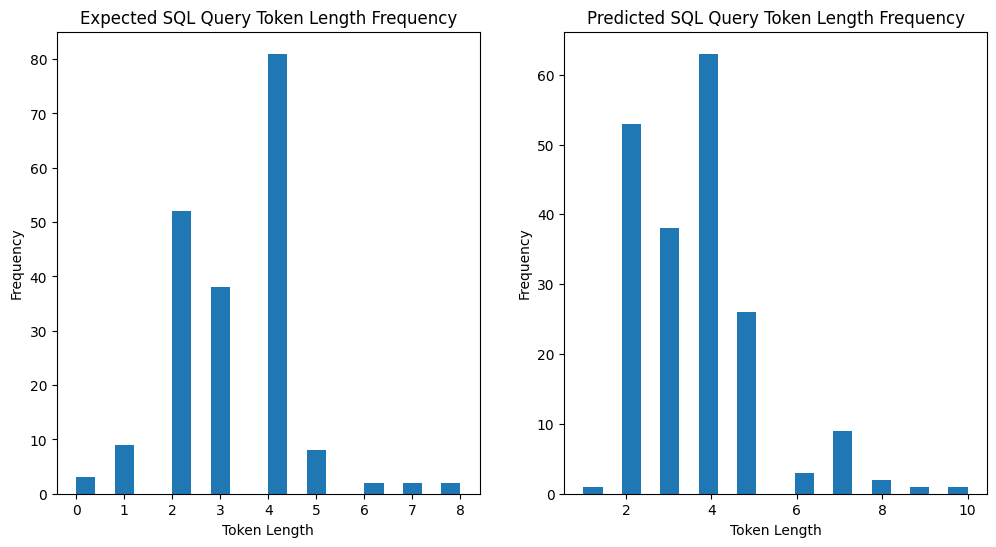

In [40]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
ax[0].hist(df["Expected count"], bins=20)
ax[0].set_xlabel('Token Length')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Expected SQL Query Token Length Frequency')

ax[1].hist(df["Predicted count"], bins=20)
ax[1].set_xlabel('Token Length')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Predicted SQL Query Token Length Frequency')

In [41]:
# context_data_option = st.selectbox(
# 'Select a input data source: ',
#             ('codellama-34b-instruct','ibm_granite-34b-code-instruct',
#              'deepseek-ai_deepseek-coder-33b-instruct','ibm_granite-13b-instruct-v2',
#               'ibm_granite-20b-code-instruct','ibm_granite-8b-code-instruct' ,
#               'kaist-ai_prometheus-8x7b-v2','meta-llama_llama-3-70b-instruct',
#               'mistralai_mixtral-8x7b-instruct-v01'
#               ),index=0)


# dict_mapping =  {
#     'codellama-34b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/codellama_34b_instruct.csv",
#     'ibm_granite-34b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/ibm_granite_34b_code_instruct.csv",
#     'deepseek-ai_deepseek-coder-33b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/deepseek-ai_deepseek-coder-33b-instruct.csv",
#     'ibm_granite-13b-instruct-v2': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/ibm_granite-13b-instruct-v2.csv",
#     'ibm_granite-20b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/ibm_granite-20b-code-instruct.csv",
#     'ibm_granite-8b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/ibm_granite-8b-code-instruct.csv",
#     'kaist-ai_prometheus-8x7b-v2': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/kaist-ai_prometheus-8x7b-v2.csv",
#     'meta-llama_llama-3-70b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/meta-llama_llama-3-70b-instruct.csv",
#     'mistralai_mixtral-8x7b-instruct-v01': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/mistralai_mixtral-8x7b-instruct-v01.csv"
#     }

In [42]:
!mkdir ../output/inference_sirion_v2/accumulated_accuracy

mkdir: cannot create directory ‘../output/inference_sirion_v2/accumulated_accuracy’: File exists


In [43]:
dict_accuracy_overall = {}

df_codellama_34b_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/codellama_34b_instruct.csv")
dict_accuracy_overall["codellama_34b_instruct"] =  df_codellama_34b_instruct[df_codellama_34b_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]

df_ibm_granite_34b_code_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite_34b_code_instruct.csv")
dict_accuracy_overall["ibm_granite_34b_code_instruct"] =  df_ibm_granite_34b_code_instruct[df_ibm_granite_34b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_Deepseek_coder_33b_instruct_data = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/Deepseek_coder_33b_instruct_data.csv")
dict_accuracy_overall["Deepseek_coder_33b_instruct_data"] =  df_Deepseek_coder_33b_instruct_data[df_Deepseek_coder_33b_instruct_data["category"]=="TOTAL"]["Execution accuracy %"].values[0]
dict_accuracy_overall


df_ibm_granite_13b_instruct_v2 = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-13b-instruct-v2.csv")
dict_accuracy_overall["ibm_granite-13b-instruct-v2"] =  df_ibm_granite_13b_instruct_v2[df_ibm_granite_13b_instruct_v2["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_ibm_granite_20b_code_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-20b-code-instruct.csv")
dict_accuracy_overall["ibm_granite-20b-code-instruct"] =  df_ibm_granite_20b_code_instruct[df_ibm_granite_20b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_kaist_ai_prometheus_8x7b_v2 = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/kaist-ai_prometheus-8x7b-v2.csv")
dict_accuracy_overall["kaist-ai_prometheus-8x7b-v2"] =  df_kaist_ai_prometheus_8x7b_v2[df_kaist_ai_prometheus_8x7b_v2["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_ibm_granite_8b_code_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-8b-code-instruct.csv")
dict_accuracy_overall["ibm_granite-8b-code-instruct"] =  df_ibm_granite_8b_code_instruct[df_ibm_granite_8b_code_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_meta_llama_llama_3_70b_instruct = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/meta-llama_llama-3-70b-instruct.csv")
dict_accuracy_overall["meta-llama_llama-3-70b-instruct"] =  df_meta_llama_llama_3_70b_instruct[df_meta_llama_llama_3_70b_instruct["category"]=="TOTAL"]["Execution accuracy %"].values[0]



df_mistralai_mixtral_8x7b_instruct_v01 = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/mistralai_mixtral-8x7b-instruct-v01.csv")
dict_accuracy_overall["mistralai_mixtral_8x7b_instruct_v01"] =  df_mistralai_mixtral_8x7b_instruct_v01[df_mistralai_mixtral_8x7b_instruct_v01["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_ibm_granite_34b_code_instruct_exEvaluator_agent = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/ibm_granite-34b-code-instruct_exEvaluator_agent.csv")
dict_accuracy_overall["ibm_granite_34b_code_instruct_exEvaluator_agent"] =  df_ibm_granite_34b_code_instruct_exEvaluator_agent[df_ibm_granite_34b_code_instruct_exEvaluator_agent["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_sirion_code_llama_7b = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/Sirion_code_llama_7b.csv")
dict_accuracy_overall["sirion_code_llama_7b"] =  df_sirion_code_llama_7b[df_sirion_code_llama_7b["category"]=="TOTAL"]["Execution accuracy %"].values[0]


df_sirion_granite_8b_inference = pd.read_csv("../output/inference_sirion_v2/accumulated_accuracy/sirion_granite_8b_inference.csv")
dict_accuracy_overall["sirion_granite_8b_inference"] =  df_sirion_granite_8b_inference[df_sirion_granite_8b_inference["category"]=="TOTAL"]["Execution accuracy %"].values[0]

dict_accuracy_overall

{'codellama_34b_instruct': 65.52,
 'ibm_granite_34b_code_instruct': 69.54,
 'Deepseek_coder_33b_instruct_data': 64.37,
 'ibm_granite-13b-instruct-v2': 27.59,
 'ibm_granite-20b-code-instruct': 43.68,
 'kaist-ai_prometheus-8x7b-v2': 63.22,
 'ibm_granite-8b-code-instruct': 58.62,
 'meta-llama_llama-3-70b-instruct': 71.26,
 'mistralai_mixtral_8x7b_instruct_v01': 66.09,
 'ibm_granite_34b_code_instruct_exEvaluator_agent': 56.9,
 'sirion_code_llama_7b': 67.24,
 'sirion_granite_8b_inference': 73.56}

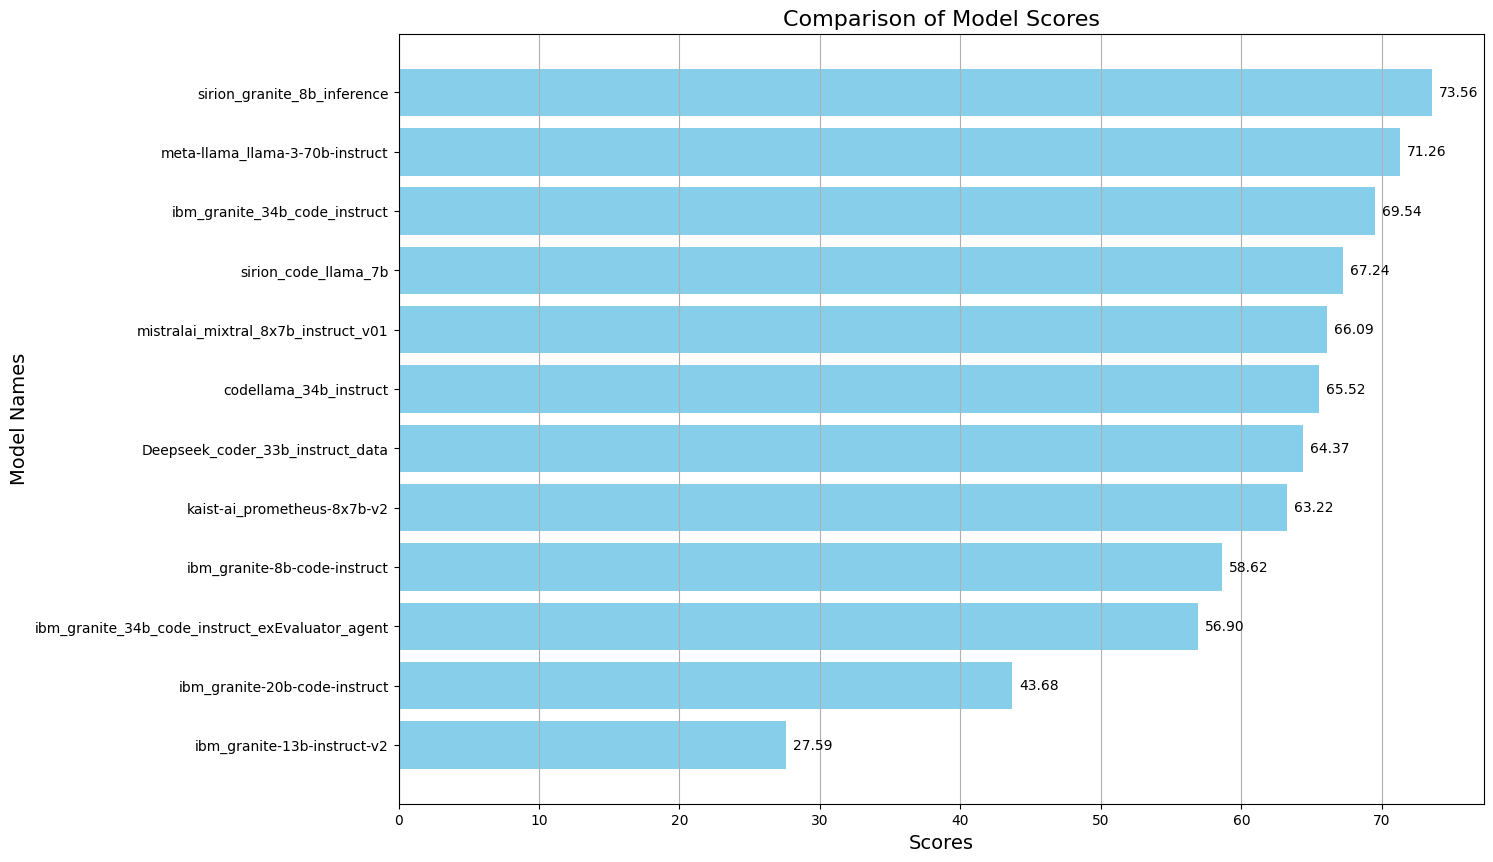

In [44]:
sorted_models = dict(sorted(dict_accuracy_overall.items(), key=lambda item: item[1]))

sorted_model_names = list(sorted_models.keys())
sorted_scores = list(sorted_models.values())

plt.figure(figsize=(14, 10))
bars = plt.barh(sorted_model_names, sorted_scores, color='skyblue')

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', 
             va='center', ha='left', fontsize=10)

plt.xlabel('Scores', fontsize=14)
plt.ylabel('Model Names', fontsize=14)
plt.title('Comparison of Model Scores', fontsize=16)
plt.grid(axis='x')

plt.show()
